# Introduction
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project my goal is to choose a combination of features from a variety of features pertaining to the former employees of Enron. I will then use an algorithm that helps me predict whether this person is a Person of Interest (POI) or not. This is a Supervised Classification problem because we are given the right answer i.e. whether the person is a POI or not. I'm going to try to get as many POIs right as possible. 

The dataset itself consists of email metadata and financial data for about 150 employees of Enron. 

I will be engineering the features, pick and tune an algorithm, test and evaluate my identifier. 

# Import Dataset

In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import svm


sys.path.append("../tools/")


from feature_format import featureFormat
from feature_format import targetFeatureSplit

### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi"]

### load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

data.dict.read()

ImportError: No module named feature_format

In [3]:
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )
data_dict

{'ALLEN PHILLIP K': {'bonus': 4175000,
  'deferral_payments': 2869717,
  'deferred_income': -3081055,
  'director_fees': 'NaN',
  'email_address': 'phillip.allen@enron.com',
  'exercised_stock_options': 1729541,
  'expenses': 13868,
  'from_messages': 2195,
  'from_poi_to_this_person': 47,
  'from_this_person_to_poi': 65,
  'loan_advances': 'NaN',
  'long_term_incentive': 304805,
  'other': 152,
  'poi': False,
  'restricted_stock': 126027,
  'restricted_stock_deferred': -126027,
  'salary': 201955,
  'shared_receipt_with_poi': 1407,
  'to_messages': 2902,
  'total_payments': 4484442,
  'total_stock_value': 1729541},
 'BADUM JAMES P': {'bonus': 'NaN',
  'deferral_payments': 178980,
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'NaN',
  'exercised_stock_options': 257817,
  'expenses': 3486,
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 'NaN'

# Outliers

First I decide to plot Salary against Bonus and try to see what the scatter plot looks like. Below we can see that there's one observation that is clearly an outlier. Upon further combing through the data, I realize that that must be the observation 'Total'. 

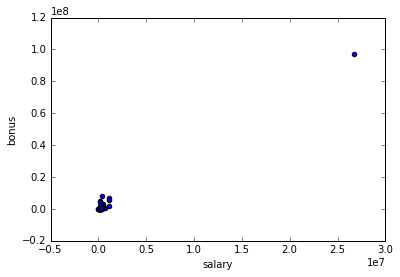

In [68]:
%matplotlib inline

features = ["salary", "bonus"]
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

I removed the values 'Total and 'The Travel Agency In The Park' and plot Salary vs Bonus again. To me, they didn’t seem to be relevant observations. I also removed all the empty values (Nan’s) from the variable ‘Salary’.

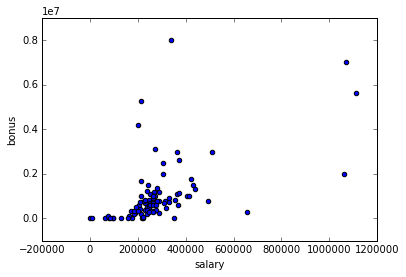

In [69]:
outliers = ["TOTAL", 'The TRAVE AGENCY IN THE PARK']

def remove_outliers(data):
    outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']
    for x in outliers:
        data_dict.pop(x, 0)

    return data
remove_outliers(data_dict)

data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()
### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))


# Exploring the Dataset

There are a total of 146 data points and 16 features in the dataset.

I decide to use all 16 features when I initially deploy the algorithm. I then continue to use 
Feature Importances to use only the most relevant features in my algorithm. 

Salary is a feature with the most number of missing values. I have removed them in the step above.

There are 18 POIs out of 146 observations. I wanted to see if I can tell how POIs behave corresponding to the different features in the dataset. Below I have plotted Salary vs Bonus. The data points are coloured to reveal whether they are a POI or not. The data points in yellow are POIs. We can see that most POIs have mid to high salaries but not all have high bonuses. There are two POIs at the very top that seem to have a very high salary and bonus. 

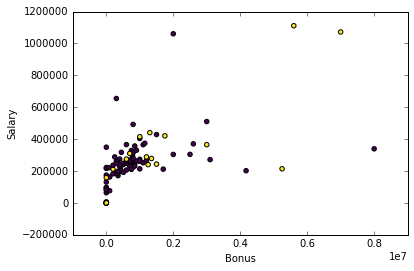

In [70]:
%matplotlib inline
features = ["poi","bonus", "salary", "expenses"]
data = featureFormat(data_dict, features)
df = pd.DataFrame(data=data)

plt.scatter(df[1], df[2], c = df[0], cmap='viridis')
plt.xlabel('Bonus')
plt.ylabel('Salary')


I then choose to plot Bonus and Expenses. Here we can see that almost all all POIs have mid to high expenses but the correlation between Bonuses and Expenses is not strong enough. 

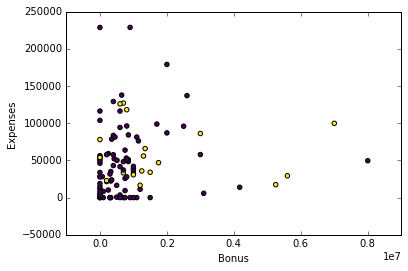

In [71]:
plt.scatter(df[1], df[3], c = df[0], cmap='viridis')
plt.xlabel('Bonus')
plt.ylabel('Expenses')

# Create New Features

I made two new features and they are both fractions:

* Fraction_from_poi_email: This is a fraction of all the messages a POI sent to this person over all the messages that the POI sent. 

* Fraction_to_poi_email: This is a fraction of all the messages a POI received from this person over all the messages received. 

My hypothesis here was that I thought POIs would send and receive messages to and from other POIs more often than send and receive messages to and from other people in the company and outside of it. 


In [72]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(var1,var2):
    new_list=[]

    for i in data_dict:
        if data_dict[i][var1]=="NaN" or data_dict[i][var2]=="NaN":
            new_list.append(0.)
        elif data_dict[i][var1]>=0:
            new_list.append(float(data_dict[i][var1])/float(data_dict[i][var2]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### Now its time to insert those features in data_dict
counter = 0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"] = fraction_from_poi_email[counter]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[counter]
    counter +=1

#Now I add my two new features to my list of variables. 
    
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"] 

### store to my_dataset for easy export below
my_dataset = data_dict


# Impact of New Features

Precision and Recall before using the new features:

| Algorithm               | Precision  |  Recall |
|-------------------------|------------|---------|
| Naive Bayes             | 0.18       |   0.5   | 
| Decision Tree           | 0.67       |   0.5   |

Precision and Recall after using the new features:

| Algorithm               | Precision  |  Recall  |
|-------------------------|------------|----------|
| Naive Bayes             | 0.18       |   0.43   | 
| Decision Tree           | 0.17       |   0.32   |

I found out that Precision and Recall for Naive Bayes don't change much. However, they decrease when the new features are added in the Decision Tree. I continue to play around with a combination of features below to see what works best.
  

# Algorithm #1 - Naive Bayes

In [73]:

##Let's make a separate dataset to use in this decision tree so that we can use my_dataset unchanged 
##later on. 
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

data_nb = featureFormat(my_dataset, features_list)

#Now its time to split the dataset into features and labels. The code below assumes that the 
#first variable is the label.

labels, features = targetFeatureSplit(data_nb)

#Now let's deploy the naive bayes algorithm using k-fold cross validation
recall_all = []
precision_all = []

kf = KFold(len(data_nb))
for train_indices, test_indices in kf:
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]
    clf = GaussianNB()
    clf.fit(features_train,labels_train)
    pred = clf.predict(features_test)
    precision_all.append(precision_score(labels_test,pred))
    recall_all.append(recall_score(labels_test,pred))
        



        
print 'Precision:', np.average(precision_all)
print 'Recall:', np.average(recall_all)

Precision: 0.175925925926
Recall: 0.438888888889


# Algorithm #2 - Decision Tree


In [74]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

data_dt = featureFormat(my_dataset, features_list)


labels, features = targetFeatureSplit(data_dt)

precision_all = []
recall_all = []

kf = KFold(len(data_dt))
for train_indices, test_indices in kf:
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]
    clf = DecisionTreeClassifier()
    clf.fit(features_train,labels_train)
    pred = clf.predict(features_test)
    precision_all.append(precision_score(labels_test,pred))
    recall_all.append(recall_score(labels_test,pred))
    importances = clf.feature_importances_
    

print 'Precision:', np.average(precision_all)
print 'Recall:', np.average(recall_all)


import pandas as pd

data_imp = pd.DataFrame(
    {'Features': features_list[1:], 
     'Importances': importances})
data_imp



Precision: 0.281746031746
Recall: 0.353703703704


,Features,Importances
0,salary,0.000000
1,bonus,0.347924
2,fraction_from_poi_email,0.000000
3,fraction_to_poi_email,0.062130
4,deferral_payments,0.000000
5,total_payments,0.079086
6,loan_advances,0.000000
7,restricted_stock_deferred,0.000000
8,deferred_income,0.284708
9,total_stock_value,0.000000


# Choosing The Algorithm

I decide to go with the Decision Tree instead of Naive Bayes because the Precision for Decision Tree is higher than Naive Bayes. Recall is a little lower than Naive Bayes but I can tune the algorithm to be able to achieve a higher Recall. 

# Feature Selection

The three features that I end up using are ‘fraction_to_poi_email’, 'fraction_from_poi_email', ‘expenses’, and ‘shared_receipt_with_poi’. 

I decide to use Feature Importances to decide which features to include in my algorithm. You can see my process below:

### Step 1: All Features

When I run my algorithm with all features, I get the following feature Importances:


| Features                  | Importances|   
|---------------------------|------------|
| salary                    | 0.000000   |   
| bonus                     | 0.000000   | 
| fraction_from_poi_email   | 0.072180   |
| fraction_to_poi_email     | 0.149133   |
| deferral_payments         | 0.000000   |
| total_payments            | 0.000000   |
| loan_advances             | 0.000000   |
| restricted_stock_deferred | 0.000000   |
| deferred_income           | 0.000000   | 
| total_stock_value         | 0.000000   |
| expenses                  | 0.265934   |
| exercised_stock_options   | 0.216512   |
| long_term_incentive       | 0.000000   |
| shared_receipt_with_poi   | 0.328822   |
| restricted_stock          | 0.037594   | 
| director_fees             | 0.000000   |

| Precision  |  Recall  |
|------------|----------|
| 0.17       |   0.29   | 


### Step 2: Remove all features with Importances = 0

I re-run the algorithm and get the following feature importances:


| Features                  | Importances|   
|---------------------------|------------|
|  fraction_from_poi_email	| 0.137999   |
|  fraction_to_poi_email	| 0.273315   |
|  expenses	                | 0.268109   |
|  exercised_stock_options	| 0.095679   |
|  shared_receipt_with_poi	| 0.134687   |
|  restricted_stock	        | 0.090212   |


| Precision  |  Recall  |
|------------|----------|
| 0.34       |   0.36   | 


### Step 3: Remove any Features with feature Importances< 0.1
I re-run the algorithm and get the following feature importances:

| Features                  | Importances|   
|---------------------------|------------|
|  fraction_from_poi_email	| 0.140088   |
|  fraction_to_poi_email	| 0.275600   |
|  expenses	                | 0.512543   |
|  shared_receipt_with_poi	| 0.071769   |

| Precision  |  Recall  |
|------------|----------|
| 0.29       |   0.35   | 

I decide to use all four features.

I did not have to do any scaling because I was using a Decision Tree and Decision Trees don’t require scaling usually. 

# Algorithm 2 - Decision Tree (With Modified Features)

In [75]:
##According to these results I pick the following features. 
features_list = ['poi', 'fraction_to_poi_email',
                     'expenses', 'shared_receipt_with_poi', 
                     'fraction_from_poi_email']
data_dt = featureFormat(my_dataset, features_list)

labels, features = targetFeatureSplit(data_dt)

precision_all = []
recall_all = []

kf = KFold(len(data_dt))
for train_indices, test_indices in kf:
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]
    clf = DecisionTreeClassifier()
    clf.fit(features_train,labels_train)
    pred = clf.predict(features_test)
    precision_all.append(precision_score(labels_test,pred))
    recall_all.append(recall_score(labels_test,pred))
    importances = clf.feature_importances_
    

print 'Precision:', np.average(precision_all)
print 'Recall:', np.average(recall_all)


import pandas as pd

data_imp = pd.DataFrame(
    {'Features': features_list[1:], 
     'Importances': importances})
data_imp



Precision: 0.292857142857
Recall: 0.353703703704


,Features,Importances
0,fraction_to_poi_email,0.275600
1,expenses,0.512543
2,shared_receipt_with_poi,0.071769
3,fraction_from_poi_email,0.140088


# Tuning An Algorithm

Algorithms have parameters and tuning an algorithm means specifying those parameters instead of using the default values. When you tune an algorithm appropriately, you can customize it to your dataset and increase accuracy, recall and precision. If you don’t tune an algorithm then your model will not be optimized for your dataset. 

We have already deployed the algorithm without tuning it. Now let's deploy the decision tree and calculate precision and recall after tuning it. A min_samples_split = 6 or higher gives the best precision and recall.

As we can see, we can see an increase in precision and recall after we tune the algorithm. 

I have used the parameter min_samples_split, which is the minimum number of samples required to split an internal node.

In [76]:
precision_all = []
recall_all = []
labels, features = targetFeatureSplit(data_dt)
kf = KFold(len(data_dt))
for train_indices, test_indices in kf:
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]
    clf = DecisionTreeClassifier(min_samples_split = 2)
    clf.fit(features_train,labels_train)
    pred = clf.predict(features_test)
    precision_all.append(precision_score(labels_test,pred))
    recall_all.append(recall_score(labels_test,pred))
    importances = clf.feature_importances_

print 'Precision and Recall after tuning the algorithm with min_samples_split = 2:'
print 'Precision:', np.average(precision_all)
print 'Recall:', np.average(recall_all)

precision_all = []
recall_all = []
kf = KFold(len(data_dt))
for train_indices, test_indices in kf:
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]
    clf = DecisionTreeClassifier(min_samples_split = 6)
    clf.fit(features_train,labels_train)
    pred = clf.predict(features_test)
    precision_all.append(precision_score(labels_test,pred))
    recall_all.append(recall_score(labels_test,pred))
    importances = clf.feature_importances_

print 'Precision and Recall after tuning the algorithm with min_samples_split = 6:'
print 'Precision:', np.average(precision_all)
print 'Recall:', np.average(recall_all)

precision_all = []
recall_all = []
kf = KFold(len(data_dt))
for train_indices, test_indices in kf:
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]
    clf = DecisionTreeClassifier(min_samples_split = 11)
    clf.fit(features_train,labels_train)
    pred = clf.predict(features_test)
    precision_all.append(precision_score(labels_test,pred))
    recall_all.append(recall_score(labels_test,pred))
    importances = clf.feature_importances_
print 'Precision and Recall after tuning the algorithm with min_samples_split = 11:'
print 'Precision:', np.average(precision_all)
print 'Recall:', np.average(recall_all)

Precision and Recall after tuning the algorithm with min_samples_split = 2:
Precision: 0.265079365079
Recall: 0.353703703704
Precision and Recall after tuning the algorithm with min_samples_split = 6:
Precision: 0.392857142857
Recall: 0.353703703704
Precision and Recall after tuning the algorithm with min_samples_split = 11:
Precision: 0.45
Recall: 0.427777777778


After tuning the algorithm manually, I decide to use GridSearchCV to tune it because:

1) It can do a more robust search over your different parameters to find the best parameters.

2) Use the "scoring" parameter to lead the parameter search process to maximize any parameter of my choice. Here I want to maximize recall because in this project, our main goal is to identify POIs so False Negatives i.e. not recognizing someone as a POI when someone is actually a POI is more harmful than False Positives i.e. recognizing someone as a POI when someone is actually not a POI. 

3) Using the "cv" parameter you can pass a cross validation object to validate your search results that best adapt to your dataset characteristics. Here I have used Stratified Shuffle Split. This is a cross-validation object provides stratified randomized folds. They make the folds by preserving the percentage of samples for each class i.e. training and testing datasets. 

In [77]:
precision_all = []
recall_all = []

kf = KFold(len(data_dt))
labels, features = targetFeatureSplit(data_dt)


for train_indices, test_indices in kf:
        features_train= [features[ii] for ii in train_indices]
        features_test= [features[ii] for ii in test_indices]
        labels_train=[labels[ii] for ii in train_indices]
        labels_test=[labels[ii] for ii in test_indices]
        parameters = {'splitter':['best', 'random'],
              'criterion':['gini', 'entropy'],
               'min_samples_split': [11]}
        clf = DecisionTreeClassifier()
        sss = StratifiedShuffleSplit(labels_train)
        clf = grid_search.GridSearchCV(clf, parameters, cv=sss, scoring="recall")
        clf.fit(features_train,labels_train)
        pred = clf.predict(features_test)
        precision_all.append(precision_score(labels_test,pred))
        recall_all.append(recall_score(labels_test,pred))
        

print 'Precision and Recall after tuning the algorithm:'
        
print 'Precision:', np.average(precision_all)
print 'Recall:', np.average(recall_all)

Precision and Recall after tuning the algorithm:
Precision: 0.0833333333333
Recall: 0.0666666666667


# Validation Of The Model

We need to validate the model by splitting it into training and testing sets to avoid overfitting. Overfitting is when we use the same dataset to train the model and then to test it. This would give us the perfect score but it would fail to give us anything useful on dataset that is yet to be seen. Validation also gives an estimate of performance on an independent dataset. 

The two datasets:

1) Training dataset: You train your model on this dataset by pairing the input with expected output. 

2) Testing dataset: You test how well you have trained your model on this dataset. You can do this by using different evaluation metrics like Accuracy, Precision and Recall. 

In my project I have decided to use K-fold cross validation because this method randomly partitions the dataset into k equal size subsamples. Out of the k subsamples, one subsample is used as the testing dataset and the rest k-1 subsamples are used as training datasets. This process is repeated k times and the results are averaged to produce a single estimation. 

The advantage of k-folds cross-validation over other methods is that all observations are used for both training and testing and each observation is used for testing only once. This method is especially advantageous for our dataset because it is quite small. We have only 146 observations. It is also very skewed. Out of the 146 data points only 18 observations are POIs. K-fold cross validation uses each employee only once in the testing dataset. 


# Evaluation Metrics 

In this project, I have used Precision and Recall to evaluate my models. 

Our main goal is to identify POIs so False Negatives i.e. not recognizing someone as a POI when someone is actually a POI is more harmful than False Positives i.e. recognizing someone as a POI when someone is actually not a POI. 

Hence, we need a high Recall.

Recall is the number of True Positives divided by the sum of True Positives and the number of False Negatives. A low Recall value indicates many False Negatives. 

Recall in this project = Total number recognized as POIs that are actually POIs / (Total number recognized as POIs that are actually POIs + Total number of POIs not recognized as POIs but are POIs)

Precision is the number of True Positives divided by the sum of True Positives and False Positives. A low Precision value indicates many False Positives.

Precision in this project = Total number recognized as POIs that are actually POIS / (Total number recognized as POIs that are actually POIs + Total number of POIs recognized as POIs but are not POIs)

We can see an improvement in Recall after tuning the algorithm. 

#### Dump your classifier, dataset and features list so that anyone can run it and check your result. 

In [78]:
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )


# Conclusion
In this project, since we are trying to identify the Person of Interest (POI), we can say that according to the decision tree algorithm, 50% of the time that our algorithm identified a POI it really was a POI because our precision is 0.5 and 50% of the time if it flagged a person as POI, then it was a false alarm. 

Recall tells us that our algorithm is 42% of the time correct in flagging the POI while the other 58% of the time it was showing us a false negative which means that it would not recognize a person as a POI while he/she actually was. 

While our numbers seem to be reasonable, there is obviously room for improvement. We can keep looking into the text of the data and see if we can garner any more information from there. 

# References:

https://en.wikipedia.org/wiki/Cross-validation_(statistics)
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=sklearn+naive+bayes
http://stackoverflow.com/questions/11277432/how-to-remove-a-key-from-a-python-dictionary
http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

# Validating Model with tester.py

In [79]:
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  0.  1.], n_iter=10, test_size=0.1, random_state=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [11], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)
	Accuracy: 0.82408	Precision: 0.46426	Recall: 0.36050	F1: 0.40585	F2: 0.37737
	Total predictions: 12000	True positives:  721	False positives:  832	False negatives: 1279	True negatives: 9168

